# 互评作业2: 频繁模式与关联规则挖掘
## 作业说明
1. 问题描述
> 本次作业中，将选择1个数据集进行频繁模式和关联规则挖掘。

2. 数据说明
> 数据集包括：
Consumer & Visitor Insights For Neighborhoods  
Wine Reviews  
Oakland Crime Statistics 2011 to 2016  
Chicago Building Violations  
Trending YouTube Video Statistics  
Melbourne Airbnb Open Data  
MLB Pitch Data 2015-2018  
与第一次互评作业的数据集范围是相同的，在选择的时候可以选择之前预处理的数据集，也可以重新选择一个。  

3. 数据分析要求
> 对数据集进行处理，转换成适合进行关联规则挖掘的形式；  
找出频繁模式； 
导出关联规则，计算其支持度和置信度;  
对规则进行评价，可使用Lift、卡方和其它教材中提及的指标, 至少2种；  
对挖掘结果进行分析；  
可视化展示。

4. 提交的内容
> 对数据集进行处理的代码  
关联规则挖掘的代码  
挖掘过程的报告：展示挖掘的过程、结果和你的分析  
所选择的数据集在README中说明，数据文件不要上传到Github中  

## 数据集 Oakland Crime Statistics 2011 to 2016
### Content
More details about each file are in the individual file descriptions.

### Context
This is a dataset hosted by the city of Oakland in California. The organization has an open data platform found here and they update their information according to the amount of data that is brought in. Explore Oakland's Data using Kaggle and all of the data sources available through the city of Oakland organization page!

+ Update Frequency: This dataset is updated daily.

### Acknowledgements
This dataset is maintained using Socrata's API and Kaggle's API. Socrata has assisted countless organizations with hosting their open data and has been an integral part of the process of bringing more data to the public.

This dataset is distributed under the following licenses: Open Data Commons Public Domain Dedication and License, NA

In [53]:
import os
from google.colab import drive
drive.mount('/content/drive') # mount google drive
co_path = '/content/drive/My Drive/Colab Notebooks/dataMining'
os.chdir(co_path)
os.listdir(co_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['cbg_patterns.csv',
 'wine-reviews',
 'oakland-crime-statistics-2011-to-2016',
 'ocs_result']

In [54]:
!pip3 install tqdm

In [0]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import re
import sys
import csv
import os

### Apriori算法
Apriori 算法流程如下  
![Apriori](images/apriori-alg.png)

### 关联规则
1. 支持度
$$Sup(x)=\frac{count(X)}{all_data}$$
2. 执行度
$$conf(X \to Y)=\frac{Sup(X \cup Y}{Sup(X)}$$
3. Lift
$$lift(X \to Y)=\frac{Sup(X \cup Y}{Sup(X) \times Sup(Y)}$$
4. Jaccard
$$Jaccard(X \to Y) = \frac{X \cup Y}{Sup(X) + Sup(Y) - Sup(X \cup Y)}$$


In [0]:
from tqdm import tqdm
from progressbar import *

class Association(object):
    #首先找出所有频繁项集，然后由频繁项集产生强关联规则
    def __init__(self, min_support = 0.1, min_confidence = 0.5):
        self.min_support = min_support         # 最小支持度
        self.min_confidence = min_confidence   #  最小置信度

    def apriori(self, dataset):
        """
        Apriori algorithm
        dataset:数据集，类型为一个list，list中每个元素是一个dict，key为属性名，value为对应属性的取值
        返回生成的频繁项集
        """
        C1 = self.create_C1(dataset)
        dataset = [set(data) for data in dataset]
        L1, support_data = self.scan_D(dataset, C1)
        L = [L1]
        k = 2
        while len(L[k-2]) > 0:
            Ck = self.apriori_gen(L[k-2], k)
            Lk, support_k = self.scan_D(dataset, Ck)
            support_data.update(support_k)
            L.append(Lk)
            k += 1
        return L, support_data

    def create_C1(self, dataset):
        """
        构建全部可能的单元素候选项集合(list)
        每个单元素候选项：（属性名，属性取值）
        """
        C1 = []
        progress = ProgressBar()
        for data in progress(dataset):
            for item in data:
                if [item] not in C1:
                    C1.append([item])
        return [frozenset(item) for item in C1]

    def scan_D(self, dataset, Ck):
        """
        根据待选项集Ck的情况，判断数据集D中Ck元素的出现频率
        过滤掉低于最小支持度的项集
        """
        Ck_count = dict()
        for data in dataset:
            for cand in Ck:
                if cand.issubset(data):
                    if cand not in Ck_count:
                        Ck_count[cand] = 1
                    else:
                        Ck_count[cand] += 1

        num_items = float(len(dataset))
        return_list = []
        support_data = dict()
        # 过滤非频繁项集
        for key in Ck_count:
            support  = Ck_count[key] / num_items
            if support >= self.min_support:
                return_list.insert(0, key)
            support_data[key] = support
        return return_list, support_data

    def apriori_gen(self, Lk, k):
        #合并元素时容易出现重复,针对包含k个元素的频繁项集，对比每个频繁项集第k-2位是否一致
        return_list = []
        len_Lk = len(Lk)
        for i in range(len_Lk):
            for j in range(i+1, len_Lk):
                # 第k-2个项相同时，将两个集合合并
                L1 = list(Lk[i])[:k-2]
                L2 = list(Lk[j])[:k-2]
                L1.sort()
                L2.sort()
                if L1 == L2:
                    return_list.append(Lk[i] | Lk[j])
        return return_list

    def generate_rules(self, L, support_data):
        """
        强关联规则
        基于Apriori算法，首先从一个频繁项集开始，接着创建一个规则列表，
        其中规则右部只包含一个元素，然后对这些规则进行测试。
        接下来合并所有的剩余规则列表来创建一个新的规则列表，
        其中规则右部包含两个元素。这种方法称作分级法。
        L: 频繁项集
        support_data: 频繁项集对应的支持度
        返回强关联规则列表
        """
        big_rules_list = []
        for i in range(1, len(L)):
            for freq_set in L[i]:
                H1 = [frozenset([item]) for item in freq_set]
                # 只获取有两个或更多元素的集合
                if i > 1:
                    self.rules_from_conseq(freq_set, H1, support_data, big_rules_list)
                else:
                    self.cal_conf(freq_set, H1, support_data, big_rules_list)
        return big_rules_list

    def rules_from_conseq(self, freq_set, H, support_data, big_rules_list):
        # H->出现在规则右部的元素列表
        m = len(H[0])
        if len(freq_set) > (m+1):
            Hmp1 = self.apriori_gen(H, m+1)
            Hmp1 = self.cal_conf(freq_set, Hmp1, support_data, big_rules_list)
            if len(Hmp1) > 1:
                self.rules_from_conseq(freq_set, Hmp1, support_data, big_rules_list)

    def cal_conf(self, freq_set, H, support_data, big_rules_list):
        # 评估生成的规则
        prunedH = []
        for conseq in H:
            sup = support_data[freq_set]
            conf = sup / support_data[freq_set - conseq]
            lift = conf / support_data[freq_set - conseq]
            jaccard = sup / (support_data[freq_set - conseq] + support_data[conseq] - sup)
            if conf >= self.min_confidence:
                big_rules_list.append((freq_set-conseq, conseq, sup, conf, lift,jaccard))
                prunedH.append(conseq)
        return prunedH

In [0]:
class OCS_dataset():
    def __init__(self,data_file_path,result_path,feature_list=None):
        self.data_file_path = data_file_path
        self.feature_list = feature_list
        self.result_path = result_path

    def set_feature_list(self,feature_list):
        self.feature_list = feature_list
        
    def set_data_file_path(self,data_file_path):
        self.data_file_path = data_file_path
    
    def set_result_path(result_path):
        self.result_path = result_path
    
    def data_read(self):

        data2011 = pd.read_csv(self.data_file_path+"/records-for-2011.csv", encoding="utf-8")
        data2012 = pd.read_csv(self.data_file_path+"/records-for-2012.csv", encoding="utf-8")
        data2013 = pd.read_csv(self.data_file_path+"/records-for-2013.csv", encoding="utf-8")
        data2014 = pd.read_csv(self.data_file_path+"/records-for-2014.csv", encoding="utf-8")
        data2015 = pd.read_csv(self.data_file_path+"/records-for-2015.csv", encoding="utf-8")
        data2016 = pd.read_csv(self.data_file_path+"/records-for-2016.csv", encoding="utf-8")

        """
        print(data11.info()); print(data12.info()); print(data13.info());
        print(data14.info()); print(data15.info()); print(data16.info());
        """
        
        data2012.rename(columns={"Location 1": "Location"}, inplace = True)
        data2013.rename(columns={"Location ": "Location"}, inplace = True)
        data2014.rename(columns={"Location 1": "Location"}, inplace = True)

        order=["Agency", "Location", "Area Id", "Beat", "Priority", 
               "Incident Type Id", "Incident Type Description", "Event Number"]
        data2011_2 = data2011[order]; data2012_2 = data2012[order]; data2013_2 = data2013[order]
        data2014_2 = data2014[order]; data2015_2 = data2015[order]; data2016_2 = data2016[order]

        data_all = pd.concat([data2011_2, data2012_2, data2013_2, data2014_2, data2015_2, data2016_2],
                             axis=0)
        print("合并后的数据集:"); print(data_all.info())
        data_all = data_all.dropna(how='any')

        return data_all


    def mining(self,min_support = 0.1, min_confidence = 0.5,head_n=None):
        out_path = self.result_path
        association = Association(min_support=min_support,min_confidence=min_confidence)
        data_all = self.data_read()
        rows = None
        if head_n is None:
          rows = data_all.values.tolist()
        else:
          rows = data_all.head(head_n).values.tolist()

        # 将数据转为数据字典存储
        dataset = []
        feature_names = ["Agency", "Location", "Area Id", "Beat", "Priority", 
                             "Incident Type Id", "Incident Type Description", "Event Number"]
        for data_line in rows:
            data_set = []
            for i, value in enumerate(data_line):
                if not value:
                    data_set.append((feature_names[i], 'NA'))
                else:
                    data_set.append((feature_names[i], value))
            dataset.append(data_set)
        print("挖掘开始")
        # 获取频繁项集
        freq_set, sup_rata = association.apriori(dataset)
        sup_rata_out = sorted(sup_rata.items(), key=lambda d: d[1], reverse=True)
        # 获取强关联规则列表
        strong_rules_list = association.generate_rules(freq_set, sup_rata)
        strong_rules_list = sorted(strong_rules_list, key=lambda x: x[3], reverse=True)

        print("挖掘完成！")
        # 将频繁项集输出到结果文件
        freq_set_file = open(os.path.join(out_path, 'fterms.json'), 'w')
        for (key, value) in sup_rata_out:
            result_dict = {'set': None, 'sup': None}
            set_result = list(key)
            sup_result = value
            if sup_result < association.min_support:
                continue
            result_dict['set'] = set_result
            result_dict['sup'] = sup_result
            json_str = json.dumps(result_dict, ensure_ascii=False)
            freq_set_file.write(json_str + '\n')
        freq_set_file.close()

        # 将关联规则输出到结果文件
        rules_file = open(os.path.join(out_path, 'rules.json'), 'w')
        for result in strong_rules_list:
            result_dict = {'X_set': None, 'Y_set': None, 'sup': None, 'conf': None, 'lift': None, 'jaccard': None}
            X_set, Y_set, sup, conf, lift, jaccard = result
            result_dict['X_set'] = list(X_set)
            result_dict['Y_set'] = list(Y_set)
            result_dict['sup'] = sup
            result_dict['conf'] = conf
            result_dict['lift'] = lift
            result_dict['jaccard'] = jaccard

            json_str = json.dumps(result_dict, ensure_ascii=False)
            rules_file.write(json_str + '\n')
        rules_file.close()
        print("结果存储完成！")

In [40]:
ocs = OCS_dataset(data_file_path="./oakland-crime-statistics-2011-to-2016",
                 result_path="./ocs_result")
ocs.mining(min_support = 0.1, min_confidence = 0.5,head_n=50000)

合并后的数据集:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046388 entries, 0 to 110827
Data columns (total 8 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Agency                     1046384 non-null  object 
 1   Location                   1046276 non-null  object 
 2   Area Id                    864023 non-null   object 
 3   Beat                       1040583 non-null  object 
 4   Priority                   1046384 non-null  float64
 5   Incident Type Id           1046384 non-null  object 
 6   Incident Type Description  1045996 non-null  object 
 7   Event Number               1046384 non-null  object 
dtypes: float64(1), object(7)
memory usage: 71.8+ MB
None


  2% (1253 of 50000) |                   | Elapsed Time: 0:00:00 ETA:   0:00:06

挖掘开始


100% (50000 of 50000) |##################| Elapsed Time: 0:01:39 Time:  0:01:39


挖掘完成！
结果存储完成！


## 结果可视化

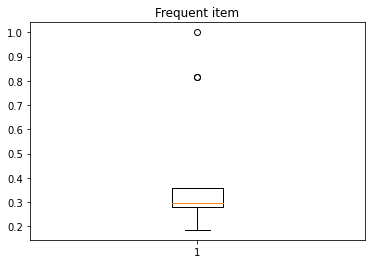

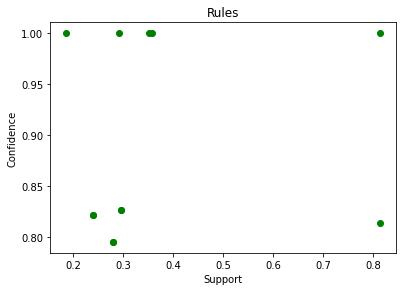

In [75]:
with open("./ocs_result/fterms.json") as f1:
  freq = [json.loads(each) for each in f1.readlines()]
  freq_sup = [each["sup"] for each in freq]
  plt.figure()
  plt.title("Frequent item")
  plt.boxplot(freq_sup)
  plt.show()

with open("./ocs_result/rules.json") as f2:
  rules = [json.loads(each) for each in f2.readlines()]
  rules_sup = [each["sup"] for each in rules]
  rules_conf = [each["conf"] for each in rules]
  fig=plt.figure("rule")
  ax=fig.add_axes([0.1,0.1,0.8,0.8])
  ax.set_title("Rules")
  ax.scatter(rules_sup, rules_conf, marker='o', color='green')
  ax.set_xlabel("Support")
  ax.set_ylabel("Confidence")
  plt.show()

## 挖掘结果分析
### 频繁项集
将频繁项集按照支持度由大到小排序，结果如下：

In [73]:
freq

[{'set': [['Agency', 'OP']], 'sup': 1.0},
 {'set': [['Priority', 2.0]], 'sup': 0.81442},
 {'set': [['Priority', 2.0], ['Agency', 'OP']], 'sup': 0.81442},
 {'set': [['Area Id', 1.0]], 'sup': 0.35754},
 {'set': [['Area Id', 1.0], ['Agency', 'OP']], 'sup': 0.35754},
 {'set': [['Area Id', 3.0]], 'sup': 0.35092},
 {'set': [['Area Id', 3.0], ['Agency', 'OP']], 'sup': 0.35092},
 {'set': [['Priority', 2.0], ['Area Id', 1.0]], 'sup': 0.29566},
 {'set': [['Priority', 2.0], ['Area Id', 1.0], ['Agency', 'OP']],
  'sup': 0.29566},
 {'set': [['Area Id', 2.0]], 'sup': 0.29154},
 {'set': [['Area Id', 2.0], ['Agency', 'OP']], 'sup': 0.29154},
 {'set': [['Priority', 2.0], ['Area Id', 3.0]], 'sup': 0.27902},
 {'set': [['Priority', 2.0], ['Area Id', 3.0], ['Agency', 'OP']],
  'sup': 0.27902},
 {'set': [['Priority', 2.0], ['Area Id', 2.0]], 'sup': 0.23974},
 {'set': [['Priority', 2.0], ['Area Id', 2.0], ['Agency', 'OP']],
  'sup': 0.23974},
 {'set': [['Priority', 1.0]], 'sup': 0.18556},
 {'set': [['Priorit

### 关联规则
将关联规则按照置信度由大到小排序，结果如下。
分析可知，Ared Id的置信度最高，说明该地区犯罪事实出现最多，而且Area Id与Priority的关联度较高。

In [70]:
rules

[{'X_set': [['Area Id', 3.0]],
  'Y_set': [['Agency', 'OP']],
  'conf': 1.0,
  'jaccard': 0.35092000000000007,
  'lift': 2.8496523424142253,
  'sup': 0.35092},
 {'X_set': [['Area Id', 2.0]],
  'Y_set': [['Agency', 'OP']],
  'conf': 1.0,
  'jaccard': 0.2915400000000001,
  'lift': 3.4300610550867803,
  'sup': 0.29154},
 {'X_set': [['Priority', 2.0]],
  'Y_set': [['Agency', 'OP']],
  'conf': 1.0,
  'jaccard': 0.81442,
  'lift': 1.2278676849782666,
  'sup': 0.81442},
 {'X_set': [['Area Id', 1.0]],
  'Y_set': [['Agency', 'OP']],
  'conf': 1.0,
  'jaccard': 0.35754,
  'lift': 2.796889858477373,
  'sup': 0.35754},
 {'X_set': [['Priority', 1.0]],
  'Y_set': [['Agency', 'OP']],
  'conf': 1.0,
  'jaccard': 0.18556,
  'lift': 5.389092476826902,
  'sup': 0.18556},
 {'X_set': [['Area Id', 1.0]],
  'Y_set': [['Priority', 2.0]],
  'conf': 0.82692845555742,
  'jaccard': 0.33739586899463647,
  'lift': 2.312827811034905,
  'sup': 0.29566},
 {'X_set': [['Area Id', 1.0]],
  'Y_set': [['Priority', 2.0], ['